# Predictive Modeling

This notebook develops an AFL player performance prediction workflow using position-specific models for Forward, Midfield, Ruck, and Defender roles. 

It first fits an interpretable linear modeling pipeline, then compares it against Random Forest and XGBoost using a chronological train/validation/test split. Finally, it summarizes model performance across positions and uses coefficient plots and SHAP explanations to translate predictive patterns into role-level football insights.

# Linear Regression

## 0. Imports & Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns', 60)
pd.set_option('display.float_format', '{:.4f}'.format)

SEED = 42
np.random.seed(SEED)

## 1. Load & Prepare Data

In [2]:
df = pd.read_csv("df_final_final.csv")
print(df.shape)
print()
print(df.dtypes)

(127116, 32)

GameId                 str
Year                 int64
Team                   str
PlayerId             int64
Disposals            int64
Marks                int64
Goals                int64
Behinds              int64
HitOuts              int64
Tackles              int64
Rebounds             int64
Inside50s            int64
Clearances           int64
Clangers             int64
Frees                int64
FreesAgainst         int64
ContestedMarks       int64
MarksInside50        int64
OnePercenters        int64
GoalAssists          int64
%Played              int64
PlayerName             str
Height               int64
Weight               int64
PrimaryPosition        str
BMI                float64
AwayTeam               str
AvgTemp            float64
TempRange          float64
IsRainy              int64
Age                  int64
Total_Score          int64
dtype: object


In [3]:
# ── Derived columns ──────────────────────
df['IsHome']     = (df['Team'] != df['AwayTeam']).astype(int)
df['Post666']    = (df['Year'] >= 2019).astype(int)
df['PostStand']  = (df['Year'] >= 2021).astype(int)
df['RotEra']     = pd.cut(
    df['Year'],
    bins=[2011, 2015, 2019, 2025],
    labels=['high', 'medium', 'low']
)

# One-hot encode RotEra 
rot_dummies = pd.get_dummies(df["RotEra"], prefix="RotEra", drop_first=True)
df = pd.concat([df, rot_dummies], axis=1)

df = df.sort_values(['PlayerId', 'Year', 'GameId'])
df['GamesPlayed'] = df.groupby('PlayerId').cumcount() + 1

# Lagged team quality (previous-year average Total_Score per team)
team_year_mean = (
    df.groupby(['Team', 'Year'], as_index=False)['Total_Score']
      .mean()
      .rename(columns={'Total_Score': 'TeamQuality'})
      .sort_values(['Team', 'Year'])
)
team_year_mean['TeamQuality'] = team_year_mean.groupby('Team')['TeamQuality'].shift(1)
df = df.merge(team_year_mean[['Team', 'Year', 'TeamQuality']], on=['Team', 'Year'], how='left')

# Squared terms
df['BMISquared'] = df['BMI'] ** 2
df['AgeSquared'] = df['Age'] ** 2

print(df[['Total_Score', 'IsHome', 'Post666', 'PostStand', 'TeamQuality']].describe())
print()
print(df.columns)

       Total_Score      IsHome     Post666   PostStand  TeamQuality
count  127116.0000 127116.0000 127116.0000 127116.0000  118052.0000
mean        3.6698      0.5311      0.5026      0.3752       3.6539
std         5.9751      0.4990      0.5000      0.4842       0.5880
min         0.0000      0.0000      0.0000      0.0000       2.1283
25%         0.0000      0.0000      0.0000      0.0000       3.2298
50%         0.0000      1.0000      1.0000      0.0000       3.7190
75%         6.0000      1.0000      1.0000      1.0000       4.0379
max        82.0000      1.0000      1.0000      1.0000       5.3436

Index(['GameId', 'Year', 'Team', 'PlayerId', 'Disposals', 'Marks', 'Goals',
       'Behinds', 'HitOuts', 'Tackles', 'Rebounds', 'Inside50s', 'Clearances',
       'Clangers', 'Frees', 'FreesAgainst', 'ContestedMarks', 'MarksInside50',
       'OnePercenters', 'GoalAssists', '%Played', 'PlayerName', 'Height',
       'Weight', 'PrimaryPosition', 'BMI', 'AwayTeam', 'AvgTemp', 'TempRange',


## 2. Feature Construction Helpers

In [4]:
# ── Universal base features ───────────────────────────────────
BASE_FEATURES = [
    # Era / rule
    'Post666', 'PostStand', 'RotEra_medium', 'RotEra_low',
    # Weather
    'AvgTemp', 'TempRange', 'IsRainy',
    # Player physical
    'Height', 'Weight', 'BMI', 'Age', 'BMISquared', 'AgeSquared',
    # Context
    'IsHome', 'TeamQuality',
    # Universal performance
    'Disposals', 'Marks', 'Clangers', 'Frees', 'FreesAgainst', '%Played', 'GamesPlayed',
]

# Position-specific extra predictors
POSITION_EXTRAS = {
    'Forward':  ['MarksInside50', 'Tackles'],
    'Midfield': ['Inside50s', 'GoalAssists'],
    'Ruck':     ['Clearances', 'ContestedMarks'],
    'Defender': ['OnePercenters', 'Tackles'],
}

# Target per position
TARGETS = {
    'Forward':  'Total_Score',
    'Midfield': 'Clearances',
    'Ruck':     'HitOuts',
    'Defender': 'Rebounds',
}

# Interaction groups
GROUP_A = ['Height', 'Weight', 'BMI']
GROUP_B = ['IsHome', 'Post666', 'PostStand', 'RotEra_medium', 'RotEra_low']

def build_interaction_features(df_pos):
    """Build all cross-product interactions between Group A and Group B."""
    idf = {}
    for a in GROUP_A:
        for b in GROUP_B:
            col = f'{a}_x_{b}'
            idf[col] = df_pos[a] * df_pos[b]
    return pd.DataFrame(idf, index=df_pos.index)

def get_feature_matrix(df_pos, position):
    """Assemble the full candidate feature matrix for a given position."""
    all_cols = BASE_FEATURES + POSITION_EXTRAS[position]
    X = df_pos[all_cols].copy()
    interactions = build_interaction_features(df_pos)
    X = pd.concat([X, interactions], axis=1)
    return X

def metrics(y_true, y_pred, label=''):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    print(f'  {label:12s} → MAE={mae:.4f}  RMSE={rmse:.4f}  R²={r2:.4f}')
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

## 3. Preprocessing Helpers

In [5]:
from scipy import stats

def remove_outliers_iqr(df_pos, target, factor=3.0):
    """
    Remove rows where the target is more than `factor` IQR from the median.
    A generous factor (3) is used to avoid over-trimming match-level data.
    """
    Q1, Q3 = df_pos[target].quantile(0.25), df_pos[target].quantile(0.75)
    IQR = Q3 - Q1
    mask = (df_pos[target] >= Q1 - factor * IQR) & (df_pos[target] <= Q3 + factor * IQR)
    n_removed = (~mask).sum()
    print(f'  Outlier removal: dropped {n_removed} rows ({100*n_removed/len(df_pos):.2f}%)')
    return df_pos[mask].copy()

def log1p_skewed(X_df, threshold=1.0, cols_to_skip=None):
    """
    Apply log1p to numeric columns with skewness above `threshold`.
    Returns transformed copy and list of transformed columns.
    """
    if cols_to_skip is None:
        cols_to_skip = []
    X = X_df.copy()
    transformed = []
    for col in X.select_dtypes(include=[np.number]).columns:
        if col in cols_to_skip:
            continue
        if X[col].min() < 0:          # log1p requires non-negative
            continue
        sk = X[col].skew()
        if abs(sk) > threshold:
            X[col] = np.log1p(X[col])
            transformed.append(col)
    if transformed:
        print(f'  log1p applied to: {transformed}')
    return X, transformed

# Columns that should never be log-transformed (binary / ordinal flags)
SKIP_LOG = ['IsHome', 'Post666', 'PostStand', 'RotEra_medium', 'RotEra_low', 'IsRainy']

## 4. Model-Fitting Helper (Lasso for Feature Selection → OLS Final)

In [47]:
def fit_position_model(position, df_global, verbose=True):
    """
    Full pipeline for one position:
      1. Filter to position
      2. Build feature matrix
      3. Train / val / test split
      4. Outlier removal (train only)
      5. Log-transform skewed features
      6. RobustScaler
      7. LassoCV for feature selection on train+val (no test leakage)
      8. Final OLS on selected features
      9. Evaluate on val + test
     10. Coefficient plot
    """
    target = TARGETS[position]
    print(f'\n{"="*70}')
    print(f'POSITION: {position}  |  TARGET: {target}')
    print('='*70)

    # ── 1. Filter ────────────────────────────────────────────────────────────
    pos_df = df_global[df_global['PrimaryPosition'] == position].copy()
    print(f'  Rows for {position}: {len(pos_df):,}')

    # ── 2. Feature matrix ────────────────────────────────────────────────────
    X_all = get_feature_matrix(pos_df, position)
    y_all = pos_df[target]

    # Drop rows where any required column is NaN
    combined = pd.concat([X_all, y_all], axis=1).dropna()
    X_all = combined.drop(columns=[target])
    y_all = combined[target]
    year_all = pos_df.loc[combined.index, 'Year']

    # ── 3. Time-based split ──────────────────────────────────────────────────
    train_mask = year_all <= 2022
    val_mask   = (year_all >= 2023) & (year_all <= 2024)
    test_mask  = year_all == 2025

    X_tr, y_tr = X_all[train_mask], y_all[train_mask]
    X_va, y_va = X_all[val_mask],   y_all[val_mask]
    X_te, y_te = X_all[test_mask],  y_all[test_mask]
    print(f'  Train: {len(X_tr):,}  Val: {len(X_va):,}  Test: {len(X_te):,}')

    # ── 4. Outlier removal (train only) ──────────────────────────────────────
    train_combined = pd.concat([X_tr, y_tr], axis=1)
    train_combined = remove_outliers_iqr(train_combined, target)
    X_tr = train_combined.drop(columns=[target])
    y_tr = train_combined[target]

    # ── 5. Log-transform skewed features (fit on train, apply to all) ─────────
    X_tr_log, log_cols = log1p_skewed(X_tr, threshold=1.0, cols_to_skip=SKIP_LOG)
    X_va_log = X_va.copy()
    X_te_log = X_te.copy()
    for col in log_cols:
        X_va_log[col] = np.log1p(X_va[col].clip(lower=0))
        X_te_log[col] = np.log1p(X_te[col].clip(lower=0))

    # ── 6. Robust scaling (fit on train, apply to all) ────────────────────────
    scaler = RobustScaler()
    X_tr_sc = scaler.fit_transform(X_tr_log)
    X_va_sc = scaler.transform(X_va_log)
    X_te_sc = scaler.transform(X_te_log)
    feat_names = X_tr_log.columns.tolist()

    # ── 7. LassoCV feature selection (train+val, no test) ─────────────────────
    # Combine train + val for cross-validated Lasso selection
    X_sel = np.vstack([X_tr_sc, X_va_sc])
    y_sel = np.concatenate([y_tr.values, y_va.values])
    lasso_cv = LassoCV(cv=5, random_state=SEED, max_iter=10000, n_jobs=-1)
    lasso_cv.fit(X_sel, y_sel)
    selected_mask = lasso_cv.coef_ != 0
    selected_feats = [f for f, s in zip(feat_names, selected_mask) if s]
    print(f'  LassoCV selected {sum(selected_mask)}/{len(feat_names)} features  (α={lasso_cv.alpha_:.5f})')

    # Subset to selected features
    sel_idx = [feat_names.index(f) for f in selected_feats]
    X_tr_sel  = X_tr_sc[:, sel_idx]
    X_va_sel  = X_va_sc[:, sel_idx]
    X_te_sel  = X_te_sc[:, sel_idx]

    # ── 8. Final OLS on selected features ────────────────────────────────────
    ols = LinearRegression()
    ols.fit(X_tr_sel, y_tr)

    # ── 9. Evaluate ──────────────────────────────────────────────────────────
    print('\n  Performance metrics:')
    val_m  = metrics(y_va, ols.predict(X_va_sel),  label='Validation')
    test_m = metrics(y_te, ols.predict(X_te_sel),  label='Test')

    # ── 10. Coefficient table & plot ─────────────────────────────────────────
    coef_df = pd.DataFrame({
        'Feature': selected_feats,
        'Coefficient': ols.coef_
    }).sort_values('Coefficient', key=abs, ascending=False)

    print(f'\n  Top 15 features by |coefficient|:')
    print(coef_df.head(15).to_string(index=False))

    # Plot
    top_n = min(20, len(coef_df))
    plot_df = coef_df.head(top_n).sort_values('Coefficient')
    colors = ['#d62728' if c < 0 else '#1B3A57' for c in plot_df['Coefficient']]

    fig, ax = plt.subplots(figsize=(8, max(4, top_n * 0.35)))
    ax.barh(plot_df['Feature'], plot_df['Coefficient'], color=colors)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_title(f'{position} — Top {top_n} Coefficients (|value|)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Standardised coefficient')
    plt.tight_layout()
    plt.savefig(f'{position}_coefficients.png', dpi=120)
    plt.show()
    print(f'  Plot saved: {position}_coefficients.png')

    return {
        'position': position,
        'target':   target,
        'coef_df':  coef_df,
        'val_metrics':  val_m,
        'test_metrics': test_m,
        'selected_feats': selected_feats,
        'ols': ols,
    }

---
## 5. Forward — Total_Score


POSITION: Forward  |  TARGET: Total_Score
  Rows for Forward: 31,871
  Train: 21,849  Val: 5,247  Test: 2,516
  Outlier removal: dropped 20 rows (0.09%)
  log1p applied to: ['Frees', 'FreesAgainst', '%Played', 'GamesPlayed', 'MarksInside50', 'Tackles', 'Height_x_PostStand', 'Weight_x_PostStand', 'BMI_x_PostStand']
  LassoCV selected 20/39 features  (α=0.01436)

  Performance metrics:
  Validation   → MAE=4.3213  RMSE=5.7257  R²=0.4626
  Test         → MAE=4.3690  RMSE=5.7242  R²=0.4865

  Top 15 features by |coefficient|:
            Feature  Coefficient
      MarksInside50       9.7498
              Frees       1.3643
         BMISquared       1.2373
                BMI      -1.1983
          Disposals       0.8482
Weight_x_RotEra_low      -0.6716
           Clangers      -0.6566
       FreesAgainst       0.6096
        TeamQuality       0.5164
            Tackles      -0.5015
        GamesPlayed       0.4542
              Marks      -0.3818
         AgeSquared       0.2872
BMI_x_Rot

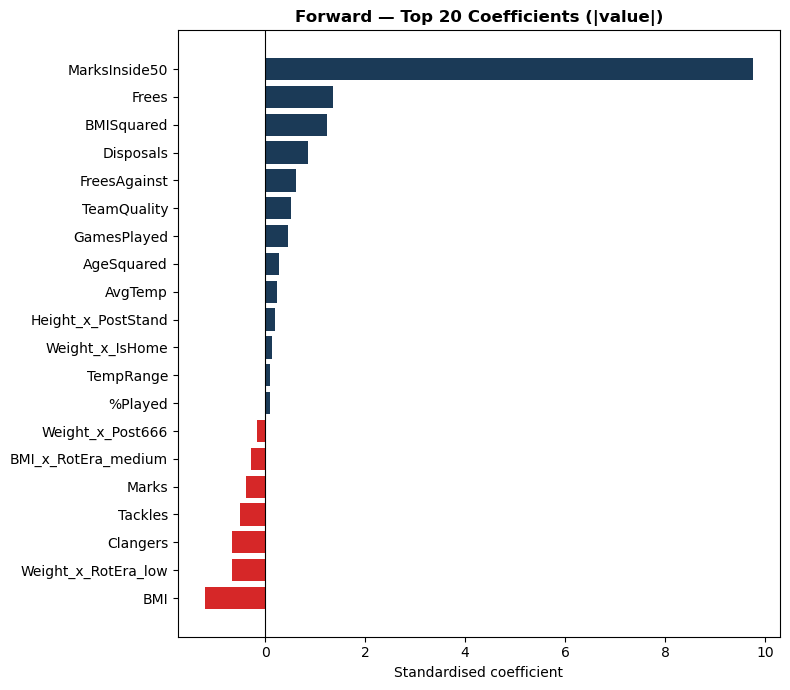

  Plot saved: Forward_coefficients.png


In [48]:
fwd_results = fit_position_model('Forward', df)

### Forward — Key Insights

MarksInside50 is by far the dominant positive driver of Total_Score, showing that scoring output for forwards is primarily tied to getting strong scoring-position possessions inside the attacking 50.

Frees and Disposals add smaller positive contributions, suggesting both scoring opportunities and general involvement help, but they are far less important than MarksInside50.

BMI and BMISquared have opposite signs, indicating a nonlinear body-type relationship with scoring rather than a purely linear effect.

Clangers is the clearest negative signal, and most interaction terms are relatively minor, implying forward scoring is explained mainly by core attacking involvement rather than rule/home context modifiers.

---
## 6. Midfield — Clearances


POSITION: Midfield  |  TARGET: Clearances
  Rows for Midfield: 40,276
  Train: 28,016  Val: 6,336  Test: 3,263
  Outlier removal: dropped 1 rows (0.00%)
  log1p applied to: ['Frees', 'FreesAgainst', '%Played', 'GoalAssists', 'Height_x_PostStand', 'Weight_x_PostStand', 'BMI_x_PostStand']
  LassoCV selected 15/39 features  (α=0.01022)

  Performance metrics:
  Validation   → MAE=1.4122  RMSE=1.8614  R²=0.5241
  Test         → MAE=1.4207  RMSE=1.8771  R²=0.5208

  Top 15 features by |coefficient|:
           Feature  Coefficient
         Disposals       2.5361
             Marks      -1.0251
             Frees       0.4525
      FreesAgainst       0.2822
            Weight       0.2347
     RotEra_medium      -0.2345
         Inside50s       0.1511
           Post666       0.1447
        BMISquared       0.1416
               Age       0.0814
           %Played      -0.0570
       GoalAssists      -0.0563
Height_x_PostStand      -0.0362
       GamesPlayed       0.0300
           AvgTemp 

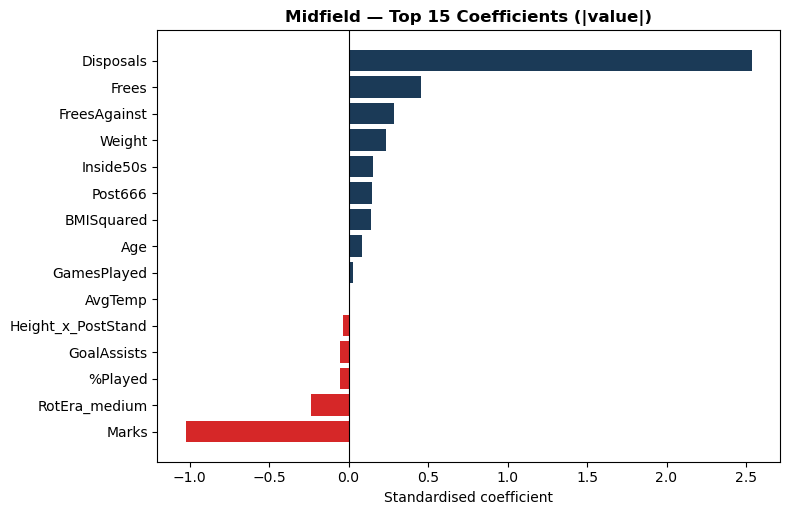

  Plot saved: Midfield_coefficients.png


  Plot saved: Midfield_coefficients.png


In [49]:
mid_results = fit_position_model('Midfield', df)

### Midfield — Key Insights

Midfield clearances are driven primarily by overall ball involvement and contested play intensity, not just isolated technical actions. Disposals is the dominant positive signal, with Frees/FreesAgainst also indicating a high-engagement, high-contact midfield role.

Positive coefficients for Weight and Inside50s imply that clearances are linked to both physical contest ability and forward progression.

The strong negative coefficient on Marks points to role differentiation within midfielders: players who generate more clearances tend to be less “outside/marking-focused” and more inside-contested-ball oriented.

Rule-era variables and BMI-related nonlinear effects suggest that clearance production is not purely player-skill based; it also depends on game environment and body-type trade-offs.

---
## 7. Ruck — HitOuts


POSITION: Ruck  |  TARGET: HitOuts
  Rows for Ruck: 8,317
  Train: 5,789  Val: 1,253  Test: 655
  Outlier removal: dropped 0 rows (0.00%)
  log1p applied to: ['BMI', 'Frees', 'FreesAgainst', '%Played', 'GamesPlayed', 'ContestedMarks', 'Height_x_PostStand', 'Weight_x_PostStand', 'BMI_x_PostStand']
  LassoCV selected 23/39 features  (α=0.00571)

  Performance metrics:
  Validation   → MAE=8.0826  RMSE=10.3261  R²=0.4948
  Test         → MAE=8.4522  RMSE=10.6394  R²=0.5482

  Top 15 features by |coefficient|:
               Feature  Coefficient
         BMI_x_Post666     -28.2724
      Height_x_Post666      26.4777
                   Age      19.2436
            AgeSquared     -16.6663
            BMISquared       6.8392
            Clearances       5.2517
                   BMI      -4.4630
                 Marks      -3.1927
      BMI_x_RotEra_low      -3.0625
                Height       2.3894
             Disposals       2.3818
           GamesPlayed       2.2910
          FreesAgai

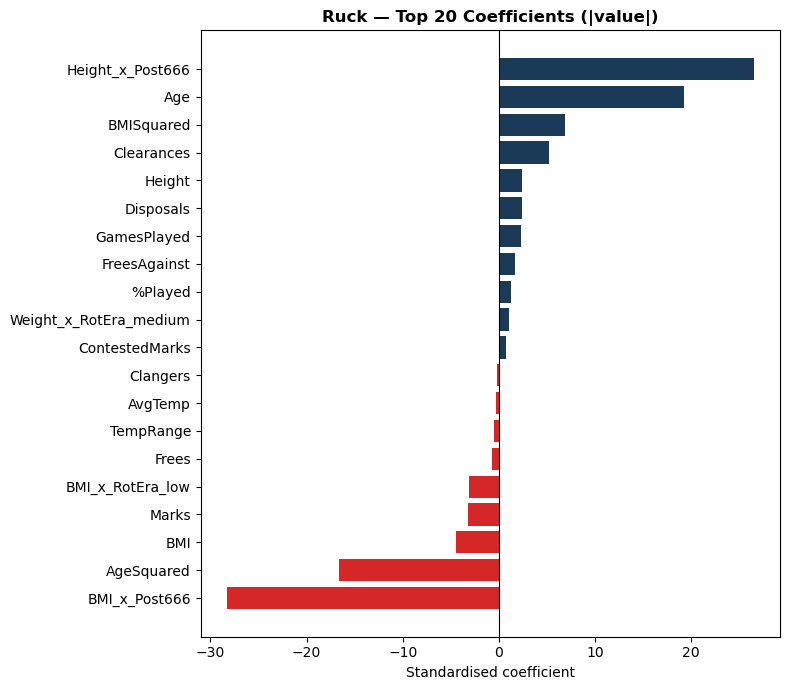

  Plot saved: Ruck_coefficients.png


  Plot saved: Ruck_coefficients.png


In [50]:
ruck_results = fit_position_model('Ruck', df)

### Ruck — Key Insights

Height × Post666 is the strongest positive coefficient by a large margin, suggesting the height advantage for rucks became much stronger after the 2019 6-6-6 rule.

Age is strongly positive while AgeSquared is strongly negative, indicating a nonlinear age effect consistent with improvement up to a point and decline afterward.

Height, Clearances, and Disposals are also positive contributors, reflecting that hit-out output is tied not only to physical size but also to broader stoppage involvement and game participation.

BMI × Post666 is strongly negative, and several BMI/era terms appear among top coefficients, suggesting body-type effects for rucks are highly context-dependent and shifted meaningfully after rule changes.

---
## 8. Defender — Rebounds


POSITION: Defender  |  TARGET: Rebounds
  Rows for Defender: 46,652
  Train: 33,562  Val: 6,386  Test: 3,180
  Outlier removal: dropped 17 rows (0.05%)
  log1p applied to: ['Frees', 'FreesAgainst', '%Played', 'OnePercenters', 'Tackles', 'Height_x_PostStand', 'Height_x_RotEra_low', 'Weight_x_PostStand', 'Weight_x_RotEra_low', 'BMI_x_PostStand', 'BMI_x_RotEra_low']
  LassoCV selected 21/39 features  (α=0.00111)

  Performance metrics:
  Validation   → MAE=1.5148  RMSE=1.9507  R²=0.3019
  Test         → MAE=1.4740  RMSE=1.8891  R²=0.2983

  Top 15 features by |coefficient|:
            Feature  Coefficient
             Weight      -3.9764
             Height       2.8478
         BMISquared       2.0004
          Disposals       1.2570
      BMI_x_Post666       1.1309
      OnePercenters       0.8115
   Weight_x_Post666      -0.6484
            Tackles      -0.1904
           Clangers       0.1684
       BMI_x_IsHome      -0.1630
       FreesAgainst      -0.1523
        GamesPlayed      

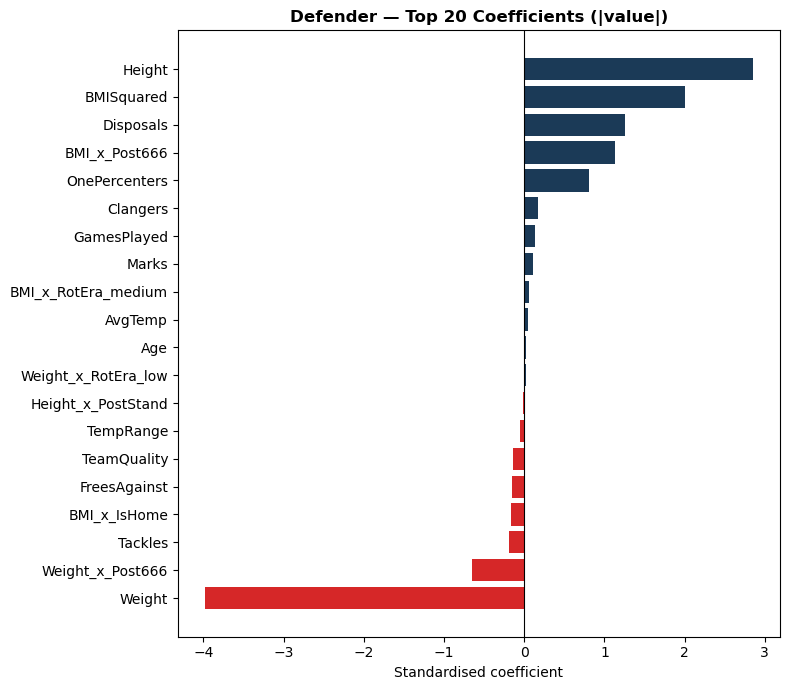

  Plot saved: Defender_coefficients.png


  Plot saved: Defender_coefficients.png


In [51]:
def_results = fit_position_model('Defender', df)

### Defender — Key Insights

Defender rebounds are driven mainly by physical profile and ball-use involvement: Height is the strongest positive factor, with Disposals and OnePercenters also contributing positively. This fits a rebound role that combines intercept/reach advantage with active defensive involvement and ball movement.

Weight is the strongest negative coefficient, while BMISquared is strongly positive and BMI-related interactions also appear, indicating a nonlinear body-type effect rather than a simple “heavier/lighter is better” pattern.

The positive BMI × Post666 term suggests the relationship between body type and rebound performance changes after the 6-6-6 rule, implying rule-era context affects how defender physical attributes translate into output.

Most other context variables are relatively small, so the main signal comes from role-specific physical and in-game involvement features.

---
# Random Forest & XGBoost Regressors

## 9. Additional Imports

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import xgboost as xgb
import shap

SEED = 42   # reuse same seed if already defined above
print(f"XGBoost version: {xgb.__version__}")

XGBoost version: 3.2.0


---
## 10. Shared Tree-Model Helper Functions

In [33]:
def build_tree_data(position, df_global):
    """
    Prepare train / val / test arrays for tree models.
    """
    target = TARGETS[position]
    pos_df = df_global[df_global['PrimaryPosition'] == position].copy()

    all_cols = BASE_FEATURES + POSITION_EXTRAS[position]
    X_all = pos_df[all_cols].copy()
    y_all = pos_df[target]

    combined = pd.concat([X_all, y_all], axis=1).dropna()
    X_all = combined.drop(columns=[target])
    y_all = combined[target]
    year_all = pos_df.loc[combined.index, 'Year']

    train_mask = year_all <= 2022
    val_mask   = (year_all >= 2023) & (year_all <= 2024)
    test_mask  = year_all == 2025

    X_tr, y_tr = X_all[train_mask], y_all[train_mask]
    X_va, y_va = X_all[val_mask],   y_all[val_mask]
    X_te, y_te = X_all[test_mask],  y_all[test_mask]

    # Outlier removal on train only
    tr_comb = pd.concat([X_tr, y_tr], axis=1)
    tr_comb = remove_outliers_iqr(tr_comb, target)
    X_tr = tr_comb.drop(columns=[target])
    y_tr = tr_comb[target]

    print(f"  {position} — Train: {len(X_tr):,}  Val: {len(X_va):,}  Test: {len(X_te):,}")
    return (X_tr.values, y_tr.values,
            X_va.values, y_va.values,
            X_te.values, y_te.values,
            X_tr.columns.tolist())

## 11. Random Forest: Fit & Evaluate

In [34]:
def fit_rf_position(position, df_global, n_estimators=300, verbose=True):
    """
    Fit a RandomForestRegressor for one position:
      1. Build data splits.
      2. Fit RF on training data.
      3. Evaluate on validation & test.
      4. Remove zero-importance features, refit.
    """
    target = TARGETS[position]
    print(f"\n{'='*65}")
    print(f"  RANDOM FOREST | {position.upper()} → {target}")
    print('='*65)

    X_tr, y_tr, X_va, y_va, X_te, y_te, feat_names = build_tree_data(position, df_global)

    # ── Step 1: Initial fit ───────────────────────────────────────────────────
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_features='sqrt',
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=SEED
    )
    rf.fit(X_tr, y_tr)

    # ── Step 2: Remove zero-importance features ───────────────────────────────
    importances = rf.feature_importances_
    nonzero_mask = importances > 0
    n_removed = (~nonzero_mask).sum()
    if n_removed > 0:
        print(f"  Removing {n_removed} zero-importance feature(s), refitting...")
        X_tr_sel = X_tr[:, nonzero_mask]
        X_va_sel = X_va[:, nonzero_mask]
        X_te_sel = X_te[:, nonzero_mask]
        feat_sel  = [f for f, m in zip(feat_names, nonzero_mask) if m]
        rf.fit(X_tr_sel, y_tr)
    else:
        X_tr_sel, X_va_sel, X_te_sel = X_tr, X_va, X_te
        feat_sel = feat_names
    print(f"  Features after pruning: {len(feat_sel)}")

    # ── Step 3: Evaluate ──────────────────────────────────────────────────────
    print("\n  Performance metrics:")
    val_m  = metrics(y_va, rf.predict(X_va_sel), label='Validation')
    test_m = metrics(y_te, rf.predict(X_te_sel), label='Test      ')

    return {
        'position': position,
        'model': rf,
        'feat_names': feat_sel,
        'val_metrics':  val_m,
        'test_metrics': test_m,
    }

## 12. XGBoost: Fit & Evaluate

In [35]:
def fit_xgb_position(position, df_global, n_estimators=400, verbose=True):
    """
    Fit an XGBRegressor for one position:
      1. Build data splits.
      2. Fit XGB with early stopping on validation set.
      3. Remove features with zero gain importance, refit.
      4. Evaluate on validation & test.
      5. Plot SHAP feature importances.
    """
    target = TARGETS[position]
    print(f"\n{'='*65}")
    print(f"  XGBOOST | {position.upper()} → {target}")
    print('='*65)

    X_tr, y_tr, X_va, y_va, X_te, y_te, feat_names = build_tree_data(position, df_global)

    # ── Step 1: Initial fit with early stopping ───────────────────────────────
    xgb_model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=5,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        verbosity=0,
        early_stopping_rounds=30,
        eval_metric='rmse',
    )
    xgb_model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        verbose=False
    )
    best_iter = xgb_model.best_iteration
    print(f"  Best iteration (early stopping): {best_iter}")

    # ── Step 2: Remove zero-importance features ─────────
    raw_imp_init = xgb_model.feature_importances_
    nonzero_mask  = raw_imp_init > 0
    n_removed = (~nonzero_mask).sum()
    if n_removed > 0:
        print(f"  Removing {n_removed} zero-gain feature(s), refitting...")
        kept_idx  = np.where(nonzero_mask)[0]
        feat_sel  = [feat_names[j] for j in kept_idx]
        X_tr_sel  = X_tr[:, kept_idx]
        X_va_sel  = X_va[:, kept_idx]
        X_te_sel  = X_te[:, kept_idx]

        xgb_model2 = xgb.XGBRegressor(
            n_estimators=best_iter + 50,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=5,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=SEED,
            n_jobs=-1,
            verbosity=0
        )
        xgb_model2.fit(X_tr_sel, y_tr)
        xgb_final = xgb_model2
    else:
        feat_sel = feat_names
        X_va_sel, X_te_sel = X_va, X_te
        X_tr_sel = X_tr
        xgb_final = xgb_model
    print(f"  Features after pruning: {len(feat_sel)}")

    # ── Step 3: Evaluate ──────────────────────────────────────────────────────
    print("\n  Performance metrics:")
    val_m  = metrics(y_va, xgb_final.predict(X_va_sel), label='Validation')
    test_m = metrics(y_te, xgb_final.predict(X_te_sel), label='Test      ')

    # ── Step 4: SHAP feature importance plot ───────────────────────────────────────
    if verbose:
        X_shap = pd.DataFrame(X_va_sel, columns=feat_sel).apply(pd.to_numeric, errors='coerce')

        try:
            explainer = shap.TreeExplainer(xgb_final)
            shap_values = explainer.shap_values(X_shap)
            mean_abs_shap = np.abs(shap_values).mean(axis=0)
            shap_imp_df = (
                pd.DataFrame({
                    'Feature': feat_sel,
                    'SHAP_Importance': mean_abs_shap
                })
                .sort_values('SHAP_Importance', ascending=False)
                .reset_index(drop=True)
            )

            print("\n  Top SHAP features (Validation):")
            print(shap_imp_df.head(15).to_string(index=False))

            shap_file = f"{position}_shap.png"
            plt.figure(figsize=(10, 6))
            shap.summary_plot(shap_values, X_shap, max_display=20, show=False)
            plt.title(f"{position} SHAP Summary", fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.savefig(shap_file, dpi=300, bbox_inches='tight')
            plt.show()

            print(f"  SHAP plot saved to: {shap_file}")

        except Exception as e:
            print(f"  SHAP plotting skipped due to error: {e}")
            shap_imp_df = None
            shap_file = None
    else:
        shap_imp_df = None
        shap_file = None
        
    return {
        'position': position,
        'model': xgb_final,
        'feat_names': feat_sel,
        'val_metrics':  val_m,
        'test_metrics': test_m,
        'shap_importance': shap_imp_df,
        'shap_plot_file': shap_file
    }

---
## 13. Forward — Total_Score


  RANDOM FOREST | FORWARD → Total_Score
  Outlier removal: dropped 20 rows (0.09%)
  Forward — Train: 21,829  Val: 5,247  Test: 2,516
  Features after pruning: 24

  Performance metrics:
  Validation   → MAE=4.2688  RMSE=5.5957  R²=0.4867
  Test         → MAE=4.4160  RMSE=5.7143  R²=0.4883


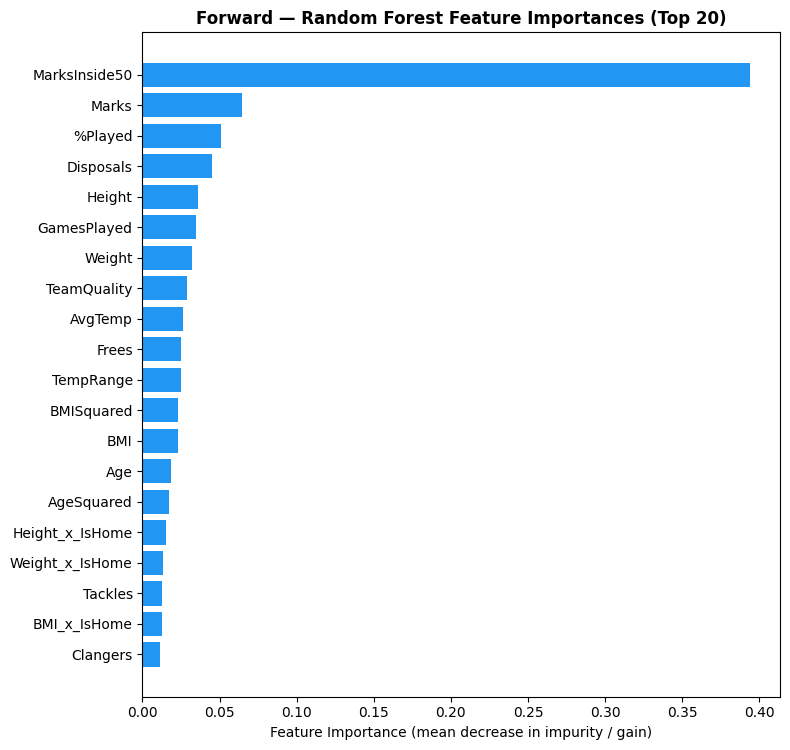

In [36]:
# ── Forward: Random Forest ─────────────────────────────────────────────────
rf_forward_results = fit_rf_position('Forward', df)


  XGBOOST | FORWARD → Total_Score
  Outlier removal: dropped 20 rows (0.09%)
  Forward — Train: 21,829  Val: 5,247  Test: 2,516
  Best iteration (early stopping): 138
  Features after pruning: 24

  Performance metrics:
  Validation   → MAE=4.0932  RMSE=5.4124  R²=0.5198
  Test         → MAE=4.1873  RMSE=5.4581  R²=0.5331

  Top SHAP features (Validation):
      Feature  SHAP_Importance
MarksInside50           3.8095
        Frees           0.6847
    Disposals           0.5927
      %Played           0.4593
  GamesPlayed           0.3431
        Marks           0.2546
     Clangers           0.2377
       Weight           0.2204
  TeamQuality           0.1853
       Height           0.1720
 FreesAgainst           0.1352
      Tackles           0.1347
          BMI           0.1266
      AvgTemp           0.1069
          Age           0.0813


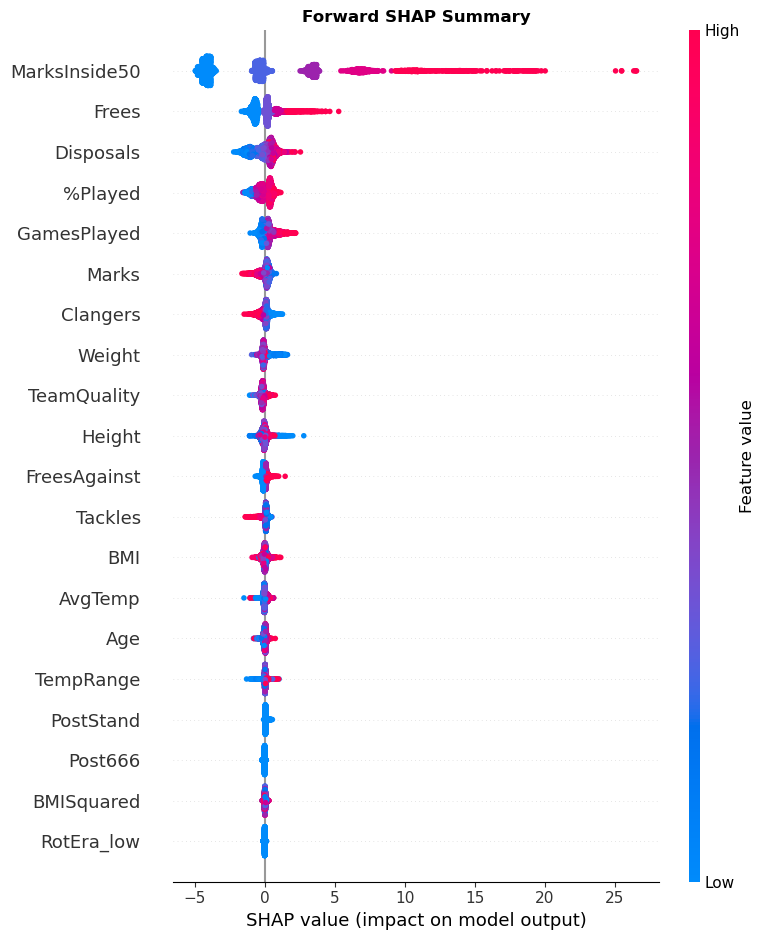

  SHAP plot saved to: Forward_shap.png


In [37]:
# ── Forward: XGBoost ───────────────────────────────────────────────────────
xgb_forward_results = fit_xgb_position('Forward', df)

### Forward — Key Insights

SHAP confirms the main LR result: MarksInside50 is the dominant driver by far. This means forward scoring is primarily determined by how often a player gets possession in dangerous scoring range, not just general activity.

Frees and Disposals remain important in SHAP (also seen in LR), suggesting that scoring output is helped by both direct scoring opportunities from umpire calls and broader ball involvement.

SHAP ranks %Played and GamesPlayed relatively high, more clearly than LR. This indicates availability and match exposure matter for converting opportunities into scoring production.

Compared with LR, SHAP highlights practical game actions more strongly, reinforcing that forward scoring is mostly driven by role-specific attacking involvement.

---
## 14. Midfield — Clearances


  RANDOM FOREST | MIDFIELD → Clearances
  Outlier removal: dropped 1 rows (0.00%)
  Midfield — Train: 28,015  Val: 6,336  Test: 3,263
  Features after pruning: 24

  Performance metrics:
  Validation   → MAE=1.4286  RMSE=1.8804  R²=0.5144
  Test         → MAE=1.4431  RMSE=1.9136  R²=0.5020


  Test         → MAE=1.4364  RMSE=1.9078  R²=0.5051


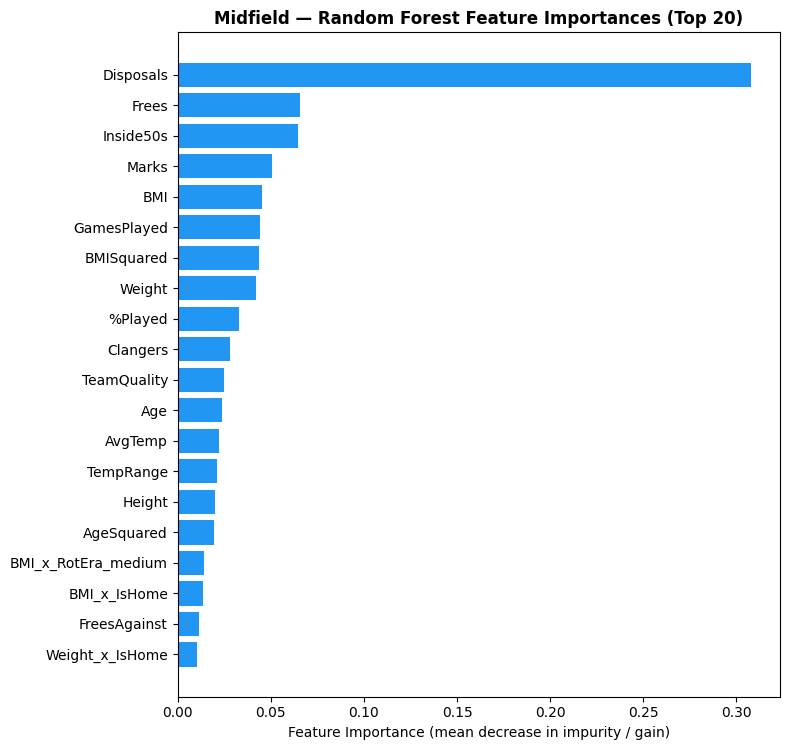

In [38]:
# ── Midfield: Random Forest ─────────────────────────────────────────────────
rf_midfield_results = fit_rf_position('Midfield', df)


  XGBOOST | MIDFIELD → Clearances
  Outlier removal: dropped 1 rows (0.00%)
  Midfield — Train: 28,015  Val: 6,336  Test: 3,263
  Best iteration (early stopping): 322
  Features after pruning: 24

  Performance metrics:
  Validation   → MAE=1.3241  RMSE=1.7705  R²=0.5695
  Test         → MAE=1.3505  RMSE=1.8109  R²=0.5541

  Top SHAP features (Validation):
      Feature  SHAP_Importance
    Disposals           1.2628
        Marks           0.4912
        Frees           0.2123
       Weight           0.2049
          BMI           0.1925
    Inside50s           0.1495
      %Played           0.1465
 FreesAgainst           0.1244
  GamesPlayed           0.0996
    PostStand           0.0660
       Height           0.0655
          Age           0.0635
RotEra_medium           0.0535
      AvgTemp           0.0379
  TeamQuality           0.0371


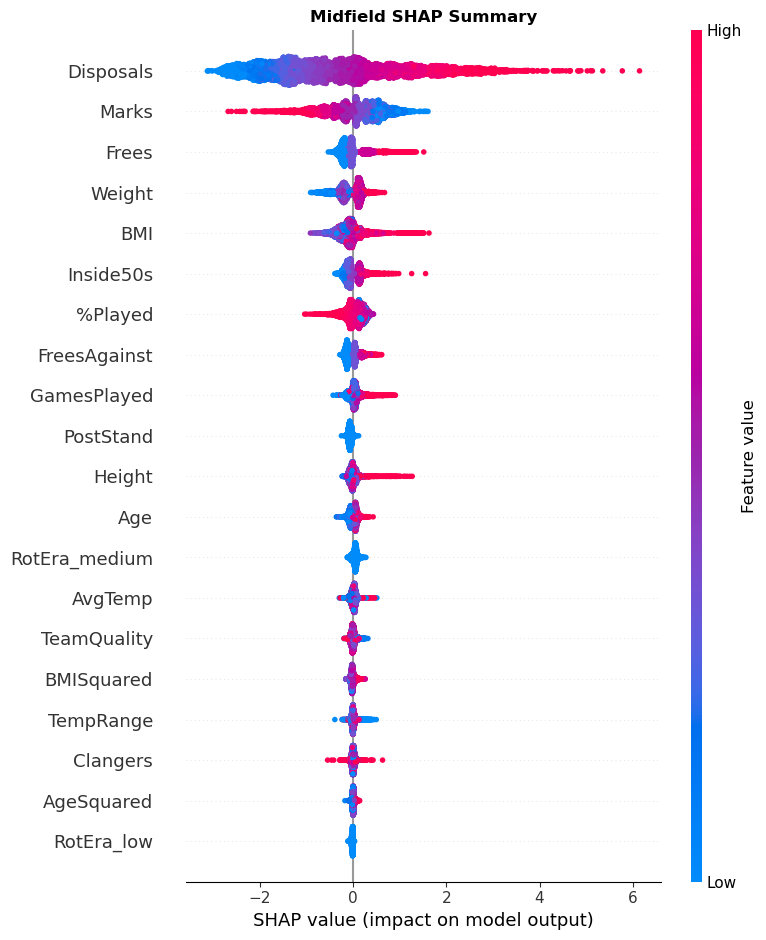

  SHAP plot saved to: Midfield_shap.png


In [39]:
# ── Midfield: XGBoost ───────────────────────────────────────────────────────
xgb_midfield_results = fit_xgb_position('Midfield', df)

### Midfield — Key Insights

SHAP supports the LR conclusion that Disposals is the key driver. Clearance is strongly tied to overall ball involvement and repeated participation in stoppage play.

SHAP also highlights Marks as highly important while LR showed a strong negative coefficient. This suggests Marks is not just important but likely nonlinear/context-dependent: marking behavior helps distinguish inside vs outside midfield roles, even if the average linear direction is negative for pure clearance production.

Frees, Weight, and %Played are important in SHAP, consistent with a contested, high-engagement midfield profile: stronger body presence, more physical contests, and more time on ground all support clearance output.

Compared with LR, SHAP gives a more nuanced picture of role differentiation (inside-ball winner vs outside-link midfielder), rather than only a single linear direction for each variable.

---
## 15. Ruck — HitOuts


  RANDOM FOREST | RUCK → HitOuts
  Outlier removal: dropped 0 rows (0.00%)
  Ruck — Train: 5,789  Val: 1,253  Test: 655
  Features after pruning: 24

  Performance metrics:
  Validation   → MAE=8.1094  RMSE=10.0512  R²=0.5213
  Test         → MAE=8.8900  RMSE=10.6052  R²=0.5511


  Test         → MAE=8.6241  RMSE=10.3477  R²=0.5726


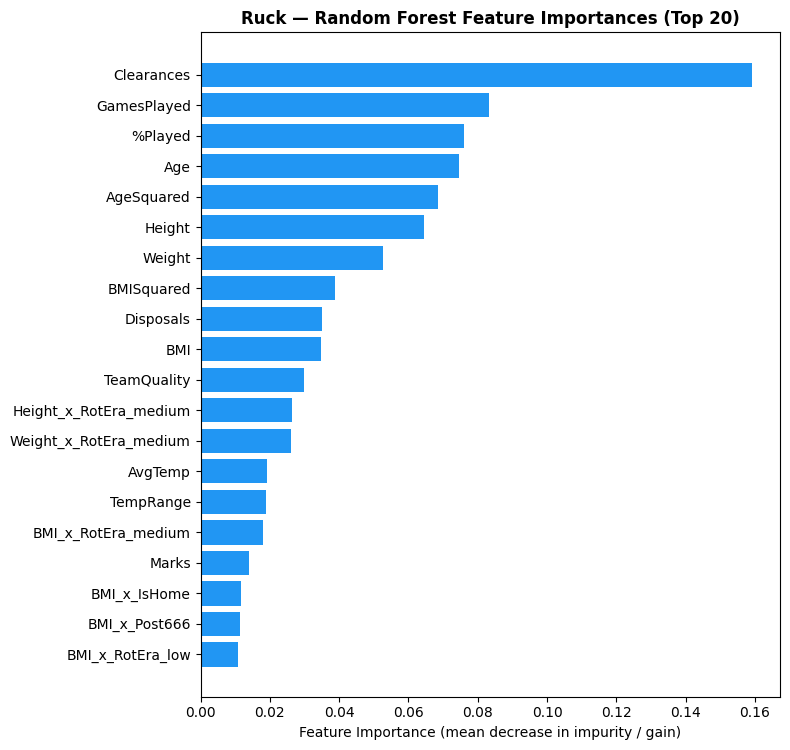

In [40]:
# ── Ruck: Random Forest ─────────────────────────────────────────────────
rf_ruck_results = fit_rf_position('Ruck', df)


  XGBOOST | RUCK → HitOuts
  Outlier removal: dropped 0 rows (0.00%)
  Ruck — Train: 5,789  Val: 1,253  Test: 655
  Best iteration (early stopping): 183
  Features after pruning: 24

  Performance metrics:
  Validation   → MAE=7.3920  RMSE=9.3924  R²=0.5820
  Test         → MAE=8.2971  RMSE=10.1889  R²=0.5856

  Top SHAP features (Validation):
      Feature  SHAP_Importance
   Clearances           3.8516
      %Played           1.7611
       Height           1.4942
  GamesPlayed           1.4636
       Weight           1.1671
   RotEra_low           0.9270
          Age           0.8853
          BMI           0.8782
        Marks           0.5860
      Post666           0.5170
  TeamQuality           0.4970
    Disposals           0.4656
   AgeSquared           0.3809
    TempRange           0.3012
RotEra_medium           0.2767


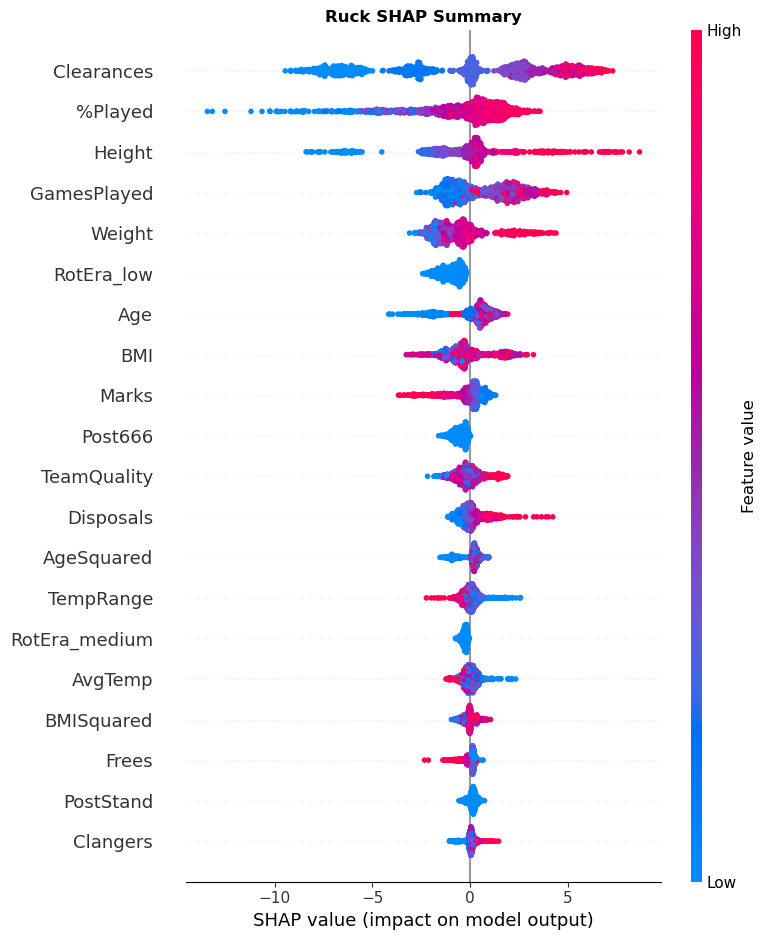

  SHAP plot saved to: Ruck_shap.png


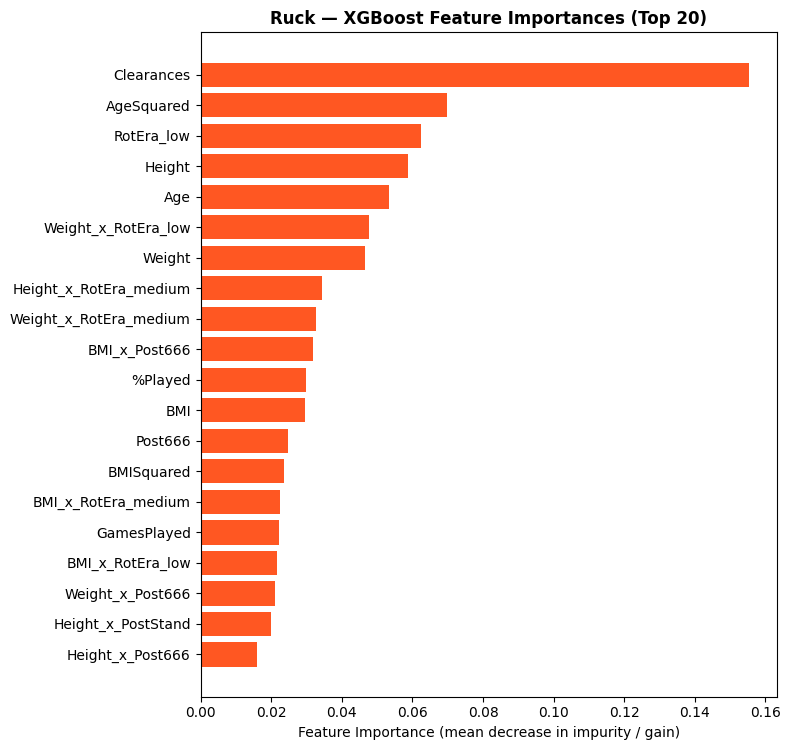

In [41]:
# ── Ruck: XGBoost ───────────────────────────────────────────────────────
xgb_ruck_results = fit_xgb_position('Ruck', df)

### Ruck — Key Insights

SHAP places the strongest emphasis on Clearances, %Played, Height, and GamesPlayed, which means hit-out production is best predicted by a mix of ruck role involvement, time on ground, physical reach, and experience. This is a more operational view of ruck output than LR’s coefficient ranking.

In contrast, LR highlighted interaction terms such as Height x Post666 very strongly. SHAP still reflects rule-era effects (Post666, RotEra dummies appear), but it suggests these effects are secondary to core ruck workload and stoppage-role variables.

Height remains a major driver in both LR and SHAP, reinforcing the on-field reality that aerial reach is fundamental to ruck contests. At the same time, SHAP shows Weight and BMI also matter, indicating body profile influences how effectively size translates into contested performance.

Compared with LR, SHAP suggests the model relies more on the practical profile of a high-usage ruck: on the field more often, involved in stoppages, and physically suited to aerial contests.

---
## 16. Defender — Rebounds


  RANDOM FOREST | DEFENDER → Rebounds
  Outlier removal: dropped 17 rows (0.05%)
  Defender — Train: 33,545  Val: 6,386  Test: 3,180
  Features after pruning: 24

  Performance metrics:
  Validation   → MAE=1.4622  RMSE=1.8866  R²=0.3470
  Test         → MAE=1.4505  RMSE=1.8579  R²=0.3213


  Test         → MAE=1.4637  RMSE=1.8759  R²=0.3081


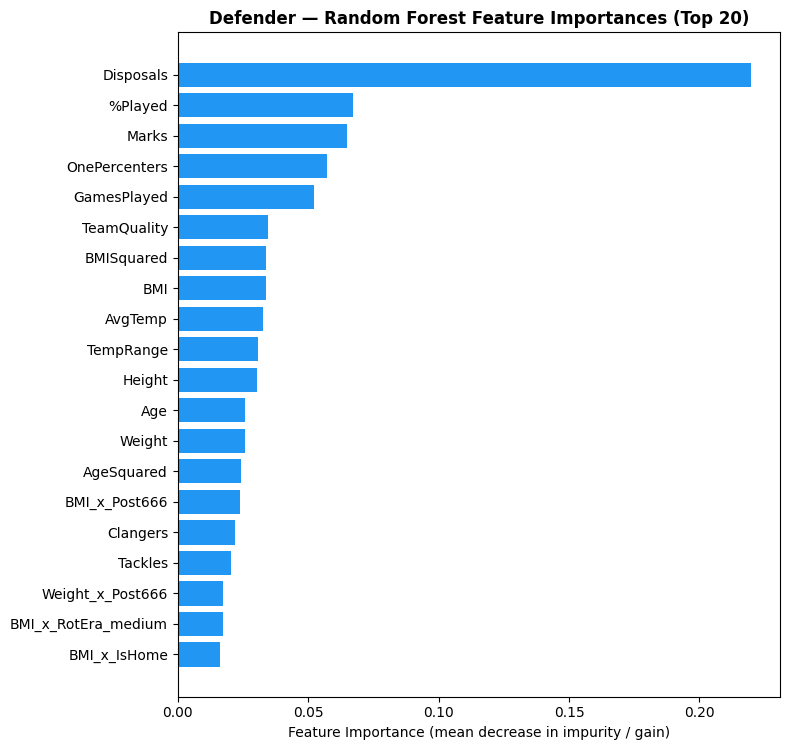

In [42]:
# ── Defender: Random Forest ─────────────────────────────────────────────────
rf_defender_results = fit_rf_position('Defender', df)


  XGBOOST | DEFENDER → Rebounds
  Outlier removal: dropped 17 rows (0.05%)
  Defender — Train: 33,545  Val: 6,386  Test: 3,180
  Best iteration (early stopping): 129
  Features after pruning: 24

  Performance metrics:
  Validation   → MAE=1.4378  RMSE=1.8648  R²=0.3620
  Test         → MAE=1.4192  RMSE=1.8290  R²=0.3422

  Top SHAP features (Validation):
      Feature  SHAP_Importance
    Disposals           0.8223
OnePercenters           0.3600
      Post666           0.2520
      %Played           0.1890
          BMI           0.1194
  GamesPlayed           0.1100
      Tackles           0.0864
       Height           0.0824
        Marks           0.0711
       Weight           0.0607
  TeamQuality           0.0559
     Clangers           0.0537
       IsHome           0.0481
   RotEra_low           0.0474
 FreesAgainst           0.0268


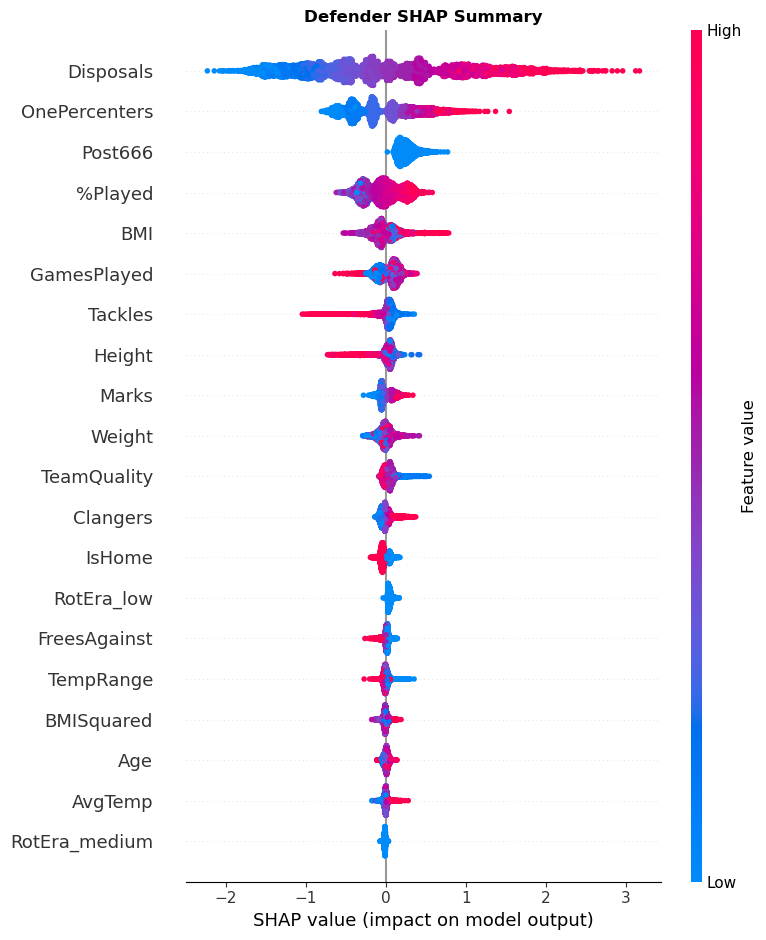

  SHAP plot saved to: Defender_shap.png


In [43]:
# ── Defender: XGBoost ───────────────────────────────────────────────────────
xgb_defender_results = fit_xgb_position('Defender', df)

### Defender — Key Insights

SHAP shifts the emphasis away from body-profile dominance seen in LR and shows that Disposals and OnePercenters are the strongest practical drivers. This means rebound output is driven mainly by defenders who both win defensive actions and then move the ball out.

Post666 appears as an important SHAP feature, suggesting the 2019 rule-era environment changed rebound opportunities in a way that matters directly for prediction, while LR captured this more through interaction terms (e.g., BMI x Post666).

Height, BMI, and Weight remain relevant in SHAP, but more as supporting conditions than the main story. This indicates physical profile helps create rebound potential.

Compared with LR, SHAP gives a more game-flow-oriented picture: rebounds are not just a “body type” outcome; they are a transition-defense behavior outcome.

---
## 17. Final Performance Summary — All Positions & Models


GRAND PERFORMANCE SUMMARY — All Positions × All Models
Position        Model      Split    MAE    RMSE     R2
 Forward    OLS/Lasso Validation 4.3213  5.7257 0.4626
 Forward    OLS/Lasso       Test 4.3690  5.7242 0.4865
 Forward RandomForest Validation 4.2688  5.5957 0.4867
 Forward RandomForest       Test 4.4160  5.7143 0.4883
 Forward      XGBoost Validation 4.0932  5.4124 0.5198
 Forward      XGBoost       Test 4.1873  5.4581 0.5331
Midfield    OLS/Lasso Validation 1.4122  1.8614 0.5241
Midfield    OLS/Lasso       Test 1.4207  1.8771 0.5208
Midfield RandomForest Validation 1.4286  1.8804 0.5144
Midfield RandomForest       Test 1.4431  1.9136 0.5020
Midfield      XGBoost Validation 1.3241  1.7705 0.5695
Midfield      XGBoost       Test 1.3505  1.8109 0.5541
    Ruck    OLS/Lasso Validation 8.0826 10.3261 0.4948
    Ruck    OLS/Lasso       Test 8.4522 10.6394 0.5482
    Ruck RandomForest Validation 8.1094 10.0512 0.5213
    Ruck RandomForest       Test 8.8900 10.6052 0.5511
    Ruck 

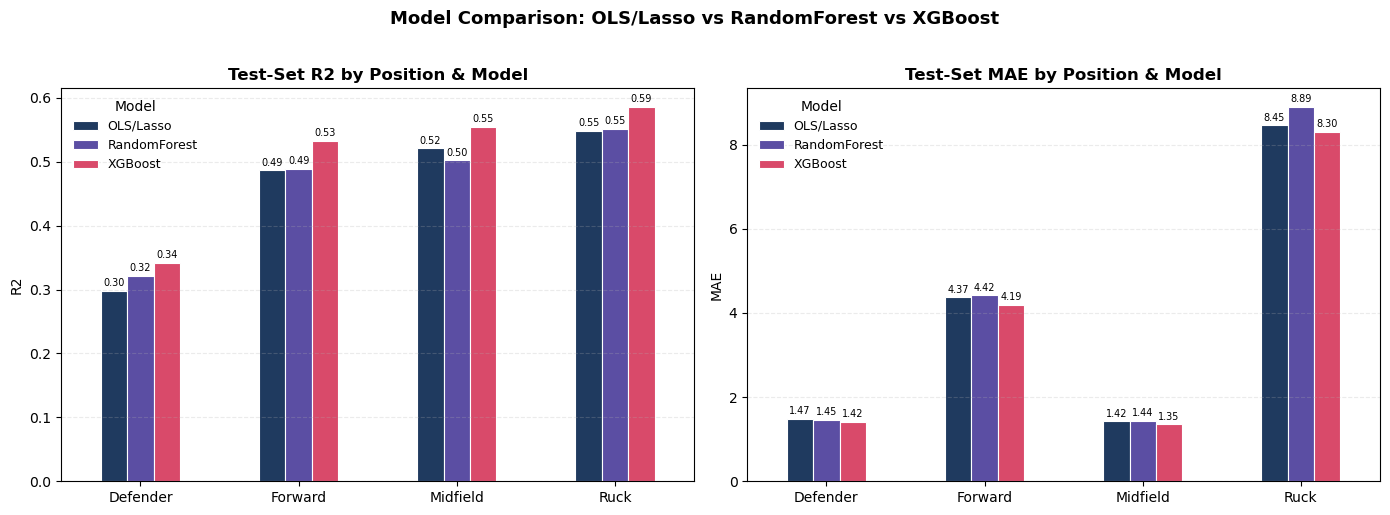

Plot saved: model_comparison.png


In [52]:
# ── Aggregate all position summaries into one table ────────────────────────────────────────
rows = []

result_map = {
    'Forward': {
        'ols': fwd_results,
        'rf': rf_forward_results,
        'xgb': xgb_forward_results
    },
    'Midfield': {
        'ols': mid_results,
        'rf': rf_midfield_results,
        'xgb': xgb_midfield_results
    },
    'Ruck': {
        'ols': ruck_results,
        'rf': rf_ruck_results,
        'xgb': xgb_ruck_results
    },
    'Defender': {
        'ols': def_results,
        'rf': rf_defender_results,
        'xgb': xgb_defender_results
    }
}

for position, res in result_map.items():
    # OLS/Lasso (LR pipeline result)
    rows.append({
        'Position': position, 'Model': 'OLS/Lasso', 'Split': 'Validation',
        **res['ols']['val_metrics']
    })
    rows.append({
        'Position': position, 'Model': 'OLS/Lasso', 'Split': 'Test',
        **res['ols']['test_metrics']
    })

    # Random Forest
    rows.append({
        'Position': position, 'Model': 'RandomForest', 'Split': 'Validation',
        **res['rf']['val_metrics']
    })
    rows.append({
        'Position': position, 'Model': 'RandomForest', 'Split': 'Test',
        **res['rf']['test_metrics']
    })

    # XGBoost
    rows.append({
        'Position': position, 'Model': 'XGBoost', 'Split': 'Validation',
        **res['xgb']['val_metrics']
    })
    rows.append({
        'Position': position, 'Model': 'XGBoost', 'Split': 'Test',
        **res['xgb']['test_metrics']
    })

all_summaries = pd.DataFrame(rows)[['Position', 'Model', 'Split', 'MAE', 'RMSE', 'R2']]

print("\n" + "="*90)
print("GRAND PERFORMANCE SUMMARY — All Positions × All Models")
print("="*90)
print(all_summaries.to_string(index=False))

# ── Visualise Test-set comparison ────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

model_colors = {
    'OLS/Lasso':    '#1F3A5F',  # deep navy
    'RandomForest': '#5B4EA3',  # muted indigo
    'XGBoost':      '#D94A6A'   # rose-magenta
}

for ax, metric in zip(axes, ['R2', 'MAE']):
    pivot = all_summaries[all_summaries['Split'] == 'Test'].pivot(
        index='Position', columns='Model', values=metric
    )

    col_order = [c for c in ['OLS/Lasso', 'RandomForest', 'XGBoost'] if c in pivot.columns]
    pivot = pivot[col_order]

    colors = [model_colors[c] for c in pivot.columns]

    pivot.plot(
        kind='bar',
        ax=ax,
        color=colors,
        edgecolor='white',
        linewidth=0.8
    )

    ax.set_title(f'Test-Set {metric} by Position & Model', fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.legend(title='Model', fontsize=9, frameon=False)
    ax.tick_params(axis='x', rotation=0)
    ax.grid(axis='y', linestyle='--', alpha=0.25)

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=7, padding=2)

plt.suptitle(
    'Model Comparison: OLS/Lasso vs RandomForest vs XGBoost',
    fontsize=13, fontweight='bold', y=1.02
)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=120, bbox_inches='tight')
plt.show()

print("Plot saved: model_comparison.png")

### Performance Summary — Key Insights

XGBoost is the strongest overall model in terms of explained variance, achieving the best R² across the four positions. However, Random Forest performs better overall on MAE, indicating that it often produces smaller average absolute prediction errors even when XGBoost captures more variance in the target. This suggests a practical trade-off: XGBoost tends to model the overall structure and variability of player performance more effectively, while Random Forest can be more robust in terms of average prediction accuracy. 

Both tree-based models generally outperform the linear baseline, especially for position targets that are influenced by nonlinear relationships and rule-/environment-dependent effects. The linear model remains a useful interpretable benchmark and performs comparatively well when the signal is dominated by a few strong role-specific predictors (e.g., forward scoring via MarksInside50).

---
## 18. Conclusions

Across positions, the results show that role-specific in-game involvement variables are the strongest predictors of output:
* Forward scoring is dominated by MarksInside50.
* Midfield clearances are driven primarily by Disposals and contested-play indicators.
* Ruck hit-outs are strongly tied to stoppage involvement, playing time, and physical profile.
* Defender rebounds are best explained by transition-defense activity (e.g., Disposals, OnePercenters) rather than body profile alone. 

XGBoost is the best overall model for capturing variance in player performance (highest R²), whereas Random Forest is often more competitive on MAE. The linear models remain valuable as an interpretable benchmark: they provide clear directional signals and highlight meaningful nonlinearities (e.g., BMI and Age squared terms) as well as rule-era interaction effects. SHAP analysis from XGBoost then complements this by offering a more practical, game-flow-oriented view of what drives predictions in the nonlinear model.